In [ ]:
#Part 1

In [5]:
import pandas as pd
import numpy as np
import sklearn as skl
import scipy as sp
import matplotlib.pyplot as mpl
import seaborn as sns
import cobra

In [6]:
def GetFingerPrints(path):
    df = pd.read_csv(path, index_col=0)
    #df.set_index('BIGG')
    return df

In [7]:
fingerprints = GetFingerPrints('ecfp_1024.csv')
print fingerprints.head()

                                                Fingerprint
BIGG                                                       
10fthf    0111110010110111101001010010111011001011000100...
12ppd__R  0000000000000000000000000000000000000000000000...
12ppd__S  0000000000000000000000000000000000000000000000...
13dpg     0100000000000000000011000000001000001000000000...
13ppd     0000000000000000000000000000000000000000000000...


In [8]:
#the filepath specifies the json used for the model, while the modelname specifies what you want to name it
def OpenModel(filepath):
    from cobra.io import load_json_model
    modelname = load_json_model(filepath);
    return modelname;

In [9]:
def GetGeneGroups(path):
    df = pd.read_csv(path,index_col =0)
    #df.set_index(['gene_group'])
    return df

In [10]:
class struMetabolite():
    """ This class is the class of a metabolite and a fingerprint"""
    def __init__(self,metabolite,structure):
        self.metabolite = metabolite
        self.structure = structure

class struReaction():
    """This class is a class of a reaction and its corrusponding metabolites and fingerprints"""
    def __init__(self,reaction,strumetabolites,signiture):
        self.reaction = reaction
        self.strumetabolites = strumetabolites
        self.signiture = signiture
class struEnzyme():
    """This class is a class of Enzymes, and their assorted strureactions"""
    def __init__(self,Enzyme,signiture):
        self.Enzyme = Enzyme
        self.signiture = signiture
class Enzyme():
    """This class is a class of Enzymes, and their assorted strureactions"""
    def __init__(self,genegroup,reactions,name):
        names = []
        for reaction in reactions:
            names.append(reaction.id)
        self.Genegroup = genegroup
        self.reactions = reactions
        self.id = name
        self.reaction_names = names

In [11]:
def MakestruMetabolite(metabolite,fingerprints):
    
    if 'C' in metabolite.formula and CutOffTail(metabolite) in fingerprints.index:
        merp = fingerprints.loc[CutOffTail(metabolite),'Fingerprint']
        fingerprint = np.array(list(map(int, list(merp))),dtype=np.int);
        strumetabolite = struMetabolite(metabolite,fingerprint);
        return strumetabolite;
    else:
        xval = 'whoops'

In [12]:
def MakestruReaction(reaction,fingerprints):
    signiture = MakeReactionSigniture(reaction,fingerprints)
    stru_metabolite = []
    for metabolite in reaction.metabolites:
        stru_metabolite.append(MakestruMetabolite(metabolite,fingerprints))
    stru_reaction = struReaction(reaction,stru_metabolite,signiture)
    return stru_reaction

In [13]:
def MakeReactionSigniture(reaction,fingerprints):
    fingerprint_list = {}
    reactant_list = []
    product_list = []
    #np.array()
    for metabolite in reaction.metabolites:
        met_short = CutOffTail(metabolite)
        if CutOffTail(metabolite) in fingerprints.index:
            if reaction.get_coefficient(metabolite.id) < 0:
                merp = fingerprints.loc[CutOffTail(metabolite),'Fingerprint']
                #print merp
                fingerprint = np.array(list(map(int, list(merp))),dtype=np.int)
                #print fingerprint
                reactant_list.append(fingerprint)
            else:
                merp = fingerprints.loc[CutOffTail(metabolite),'Fingerprint']
                #print merp
                fingerprint = np.array(list(map(int, list(merp))),dtype=np.int)
                #print fingerprint
                product_list.append(fingerprint)
            
        else:
            x_val = 'whoops'
        r_list = Combine_vectors_from_list(reactant_list)
        p_list = Combine_vectors_from_list(product_list)
    #Signiture = MakeMean(fingerprint_list)
    #print Signiture
    fingerprint_list['Reactants'] = r_list
    fingerprint_list['Products'] = p_list
    return fingerprint_list

In [14]:
'''def MakeMean(fingerprint_list):
    fpl = np.array(fingerprint_list,dtype=np.int)
    print fpl
    rows, cols = fpl.shape
    newfp = np.zeros(cols)
    l = len(fingerprint_list)
    for n in fingerprint_list:
        l = len(n)
    for i in range(0,cols):
        new_val = np.mean(fpl[0:rows,i])
        print new_val
        newfp[i] = new_val
    return newfp'''

'def MakeMean(fingerprint_list):\n    fpl = np.array(fingerprint_list,dtype=np.int)\n    print fpl\n    rows, cols = fpl.shape\n    newfp = np.zeros(cols)\n    l = len(fingerprint_list)\n    for n in fingerprint_list:\n        l = len(n)\n    for i in range(0,cols):\n        new_val = np.mean(fpl[0:rows,i])\n        print new_val\n        newfp[i] = new_val\n    return newfp'

In [15]:
def MakeEnzymes(model,path):
    """This function takes in a model and a CSV of every genegroup from the model,
    and then builds all of the enzymes(represented as a group of reactions with genes) 
    based off of a reaction group from the model"""
    GeneGroupReactions = GetGeneGroups(path)
    genes = GeneGroupReactions.index
    #print genes
    #GeneGroupReactions.set_index('gene_group')
    Enzymedict = {}
    m = 0
    for x in genes:
        #print str(x)
        reactions = GetReactionGroups(str(x),GeneGroupReactions,m)
        rxns = []
        for reaction in reactions:
            rxns.append(model.reactions.get_by_id(reaction))
        enzyme_genes = x.split(';')
        enzyme = Enzyme(enzyme_genes,rxns,str(x))
        Enzymedict[str(x)] = enzyme
        m=m+1
    return Enzymedict     

In [16]:
def MakestruEnzymes(enzymelist,fingerprints):
    struEnzyme_dict = {}
    for value in enzymelist.itervalues():
        #struEnFingerprint = MakestruEnzymeSig(i,fingerprints)
        struenzyme = struEnzyme(value,e_signatures[value.id])
        struEnzyme_dict[struenzyme.Enzyme.id] = struenzyme
    return struEnzyme_dict

In [17]:
def GetReactionGroups(genegroup,dataframe,index):
    #print dataframe
    meep = genegroup
    reactions = dataframe.associated_reactions.iloc[index]
    reactionlist = str(reactions).split(';')
    return reactionlist

In [18]:
def MakestruEnzymeSig(Enzyme,fingerprints):
    signitures = []
    for reaction in Enzyme.reactions:
        struReaction = MakestruReaction(reaction,fingerprints)
        signitures.append(struReaction.signiture)
    #Signiture = MakeMean(signitures)
    return signitures

In [19]:
def CutOffTail(metabolite):
    metabolite_id = metabolite.id
    metaboliteID = metabolite_id[:-2]
    return metaboliteID

In [20]:
def Combine_vectors_from_list(vlist):
    sumv = 0
    for i in vlist:
        sumv = i + sumv
    return sumv

In [21]:
def Check_for_multple_rxns(reaction_name,struenzyme_list):
    p = 0
    for key, value in struenzyme_list.iteritems():
        if reaction_name in struenzyme_list[key].Enzyme.reaction_names:
            if len(struenzyme_list[key].Enzyme.reactions)> 1:
                p = p + 1
    return (p > 0)

In [22]:
def make_Enzyme_reactant_vector(struenzyme,reactant_v):
    i = 0
    v = np.zeros(len(reactant_v[u'PFK']))
    for reaction in struenzyme.Enzyme.reactions:
        v = v + reactant_v[reaction.id]
        i = i + 1
    return v,(i>0)

In [19]:
"""import sciy.spatial.distance.jacard as jacard

for key, value in e:
    for key1, value1 in e:
            
            
for """

'import sciy.spatial.distance.jacard as jacard\n\nfor key, value in e:\n    for key1, value1 in e:\n            \n            \nfor '

In [23]:
#main for part 1
model = OpenModel('iML1515.json')
fingerprints = GetFingerPrints('ecfp_1024.csv')
fingerprintz = fingerprints
#print fingerprintz
enzymes = MakeEnzymes(model,'gene_groups_edited.csv')
#print fingerprints
e_signatures = {}
for key, value in enzymes.iteritems():
    enzymeID = value.id
    signature = MakestruEnzymeSig(value, fingerprints)
    e_signatures[enzymeID] = signature
print e_signatures
struenzymes = MakestruEnzymes(enzymes,fingerprintz)

{'b2690': [{'Reactants': array([0, 1, 0, ..., 0, 0, 0]), 'Products': array([0, 0, 0, ..., 0, 0, 0])}, {'Reactants': array([0, 1, 0, ..., 0, 0, 0]), 'Products': array([0, 0, 0, ..., 0, 0, 0])}, {'Reactants': array([0, 1, 0, ..., 0, 0, 0]), 'Products': array([0, 0, 0, ..., 0, 0, 0])}, {'Reactants': 0, 'Products': array([0, 0, 0, ..., 0, 0, 0])}, {'Reactants': array([1, 1, 0, ..., 0, 0, 0]), 'Products': array([0, 0, 0, ..., 0, 0, 0])}, {'Reactants': array([0, 1, 0, ..., 0, 0, 0]), 'Products': array([0, 1, 0, ..., 0, 0, 0])}, {'Reactants': array([0, 1, 0, ..., 0, 0, 0]), 'Products': array([0, 0, 0, ..., 0, 0, 0])}], 'b3821': [{'Reactants': 0, 'Products': 0}, {'Reactants': 0, 'Products': 0}, {'Reactants': 0, 'Products': 0}, {'Reactants': 0, 'Products': array([0, 0, 0, ..., 0, 0, 0])}, {'Reactants': 0, 'Products': 0}, {'Reactants': 0, 'Products': array([0, 0, 0, ..., 0, 0, 0])}, {'Reactants': 0, 'Products': array([0, 0, 0, ..., 0, 0, 0])}, {'Reactants': 0, 'Products': array([0, 0, 0, ..., 0,

TypeError: unhashable type

In [24]:
print signatures[u'PFK_3']

NameError: name 'signatures' is not defined

In [25]:
print e_signitures[]

SyntaxError: invalid syntax (<ipython-input-25-90e04010f075>, line 1)

In [26]:
import types
#print fingerprints
r_signatures = {}
for rxn in model.reactions[:]:
    rxnID = rxn.id
    signature = MakeReactionSigniture(rxn, fingerprints)
    r_signatures[rxnID] = signature
    
#print r_signatures
e = {}
d = r_signatures[u'PFK']
p = {}
for key,value in r_signatures.iteritems():
    if ~(type(value['Reactants']) is types.IntType):
        e[key] = value['Reactants']
        p[key] = Check_for_multple_rxns(key,struenzymes)
        
print p                
df5 = pd.DataFrame(p)
df4 = pd.DataFrame(e)
df4 = df4.T
df3 =  pd.DataFrame([d['Reactants'][0:len(d['Reactants'])],d['Products'][0:len(d['Products'])]])
df4.to_csv('Reactant.csv')
df5.to_csv('Reactants_in_prom_rxn.csv')

{u'CSND': False, u'GTPDPDP': False, u'EX_tym_e': False, u'PTA2': True, u'EX_xan_e': False, u'NTD10': True, u'TDPGDH': False, u'NTD12': True, u'PMEACPE': False, u'4ABZGLUH': False, u'XTSNH': True, u'DDPA': False, u'Htex': False, u'P5CD': True, u'2DGULRy': True, u'2DGULRx': True, u'GAMptspp': False, u'ETHAAL': False, u'EX_lac__D_e': False, u'P5CR': False, u'EX_glyclt_e': False, u'EX_dimp_e': False, u'GLUTRR': False, u'GTHOr': False, u'ULA4Ntppi': False, u'EX_peamn_e': False, u'MSAR': True, u'AGM4Pt2pp': False, u'EX_duri_e': False, u'KAS15': True, u'KAS14': True, u'EX_hxa_e': False, u'G5SADs': True, u'ALAALAtex': False, u'CLPNS140pp': True, u'ORNtex': False, u'2AGPG141tipp': False, u'RHAT1': False, u'S2FE2SS2': True, u'PANTS': False, u'E4PD': True, u'PLIPA2A180pp': True, u'SCYSDS': False, u'EX_ppal_e': False, u'EX_pydam_e': False, u'TREHpp': False, u'G3PSabcpp': False, u'NDP7': True, u'42A12BOOXpp': True, u'ACOAD1f': True, u'ACLS': True, u'E4PP': True, u'GLYCTO4': True, u'EX_urea_e': Fals

ValueError: If using all scalar values, you must pass an index

In [28]:
'''making an enzyme reactant vector'''
e_r_vector = {}
e_r_prom = {}
for key,value in struenzymes.iteritems():
        x = make_Enzyme_reactant_vector(value,e)
        e_r_vector[key] = x[0]
        e_r_prom[key] = x[1]


In [29]:
meee = {}
rxnnum = {}
for key, value in struenzymes.iteritems():
    meee[key] = value.Enzyme.reaction_names
    rxnnum[key] = len(value.Enzyme.reaction_names) # This gives me whether or not someting is promiscuous
df = pd.DataFrame(meee.values(),meee.keys())
meeep = {}
df2 = pd.DataFrame(r_signatures)
print r_signatures[u'PFK_3'].values()
df.to_csv('Enzyme_Reactions.csv')
df2.to_csv('Reaction_signitures.csv')

[array([0, 2, 1, ..., 0, 1, 0]), array([0, 2, 1, ..., 0, 1, 0])]


In [30]:

import sklearn.decomposition, sklearn.cluster, sklearn.manifold, sklearn.preprocessing

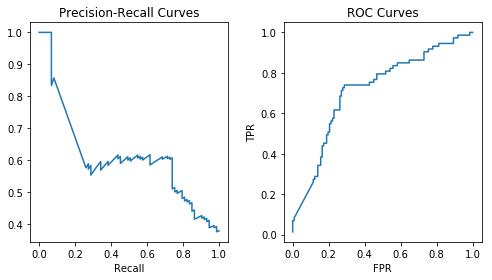

In [48]:
%matplotlib inline  
fig, ax = mpl.subplots(1,2,figsize=(7,4)); ax1,ax2 = ax
ax1.set_title('Precision-Recall Curves')
ax1.set_xlabel('Recall'); ax2.set_ylabel('Precision')
ax2.set_title('ROC Curves')
ax2.set_xlabel('FPR'); ax2.set_ylabel('TPR')
p_e = {}
for key, value in struenzymes.iteritems():
    if len(value.Enzyme.reaction_names) > 1:
        p_e[key] = True
    else:
        p_e[key] = False
        
''' Going to generate e_r_prom dictionary from scratch here '''
e_r_prom = {}
df_gene_groups = pd.read_csv('gene_groups_edited.csv', index_col=0)
for enzyme in df_gene_groups.index:
    rxns = df_gene_groups.loc[enzyme,'associated_reactions']
    e_r_prom[enzyme] = len(rxns.split(';')) > 1

''' Back to original training code '''
e_r_prom_wrapped = {}
for enzyme in e_r_prom: # casting booleans into lists, to make pandas happy
    e_r_prom_wrapped[enzyme] = [int(e_r_prom[enzyme])]
df6 = pd.DataFrame.from_dict(e_r_vector)
df7 = pd.DataFrame.from_dict(e_r_prom_wrapped)
df6 = df6.transpose() # swap index/columns
df7 = df7.transpose()

#classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
classifier = sklearn.svm.SVC(kernel='rbf')
#from sklearn.naive_bayes import MultinomialNB
#classifier = MultinomialNB(class_prior=None)
X = df6.values; n,k = X.shape # data points
y = df7.values # data labels

''' Row normalize sums to 1 (alternatively, you can normalize euclidean length) '''
row_sums = X.sum(axis=1) + 0.000000000001 # because I don't want to deal with 0s
X = X / row_sums[:, np.newaxis]

X_train, X_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)
    
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_score)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_score)
mpl.tight_layout()
ax1.plot(recall, precision)
ax2.plot(fpr, tpr) 

In [38]:
 def Cross_validation(X,y):
    cv = 5 # cross validation fold
    print("Supervised learning accuracies under 5-fold CV (+/- std)")
    clf = sklearn.svm.SVC(kernel='linear')
    scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=cv)
    print('SVM (linear) :', round(scores.mean(),3), '+/-', round(scores.std(),3))
    clf = sklearn.svm.SVC(kernel='rbf')
    scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=cv)
    print('SVM (rbf)    :', round(scores.mean(),3), '+/-', round(scores.std(),3))
    clf = sklearn.naive_bayes.MultinomialNB()
    scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=cv)
    print('Naive Bayes  :', round(scores.mean(),3), '+/-', round(scores.std(),3))
    clf = sklearn.tree.DecisionTreeClassifier()
    scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=cv)
    print('Decision Tree:', round(scores.mean(),3), '+/-', round(scores.std(),3))
    for k in range(5,20):
        clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
        scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=cv)
        print('kNN (k=' + str(k) + '):', round(scores.mean(),3), '+/-', round(scores.std(),3))

In [83]:
Cross_validation(X_train,y_train)

Supervised learning accuracies under 5-fold CV (+/- std)
('SVM (linear) :', 0.661, '+/-', 0.002)
('SVM (rbf)    :', 0.661, '+/-', 0.002)
('Naive Bayes  :', 0.661, '+/-', 0.002)
('Decision Tree:', 0.703, '+/-', 0.033)
('kNN (k=5):', 0.727, '+/-', 0.01)
('kNN (k=6):', 0.719, '+/-', 0.024)
('kNN (k=7):', 0.696, '+/-', 0.027)
('kNN (k=8):', 0.711, '+/-', 0.02)
('kNN (k=9):', 0.7, '+/-', 0.033)
('kNN (k=10):', 0.691, '+/-', 0.018)
('kNN (k=11):', 0.698, '+/-', 0.027)
('kNN (k=12):', 0.707, '+/-', 0.029)
('kNN (k=13):', 0.714, '+/-', 0.032)
('kNN (k=14):', 0.71, '+/-', 0.042)
('kNN (k=15):', 0.71, '+/-', 0.031)
('kNN (k=16):', 0.716, '+/-', 0.032)
('kNN (k=17):', 0.72, '+/-', 0.029)
('kNN (k=18):', 0.719, '+/-', 0.029)
('kNN (k=19):', 0.719, '+/-', 0.029)


In [55]:
''' Create SVM (rbf) classifier from 80% dataset, test on 20% '''
        
        
        '''X_train, X_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
        
        classifier.fit(X_train, y_train)
        y_score = classifier.decision_function(X_test)
        
        ''' Generate PR and ROC curves based on sweeping the hyperplane 
            distance threshold for labeling '''
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_score)
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_score)
        label = 'MDCS=' + str(encoding_min_size)
        ax1.plot(recall, precision, label=label)
        ax2.plot(fpr, tpr, label=label) '''

IndentationError: unexpected indent (<ipython-input-55-b8f96cbe537a>, line 4)

In [ ]:
#def metabolite_promiscuity_builder(reaction_dict,enzyme_dict)

In [ ]:
'''Attempt 1 at predicting promiscuity: Associating metabolite structures with being in a promiscuous reaction'''

In [ ]:
'''def evalulate_domain_count_model(gene_groups_file=CATH_OUT_FILE,
                                 classifier=sklearn.svm.SVC(kernel='rbf')):
    ''' Evalutes an sklearn classifier with a Precision-Recall plot
        and ROC curve. For SVM, manipulates the distance threshold 
        from the SVM hyperplane to generate PR/ROC curves. Generates
        curves for multiple domain encoding lengths. '''
    '''enz_to_cath, enz_to_prom, enz_to_ID = \
        get_enzyme_cath_annotations(gene_groups_file)'''
    fig, ax = plt.subplots(1,2,figsize=(7,4)); ax1,ax2 = ax
    ax1.set_title('Precision-Recall Curves')
    ax1.set_xlabel('Recall'); ax2.set_ylabel('Precision')
    ax2.set_title('ROC Curves')
    ax2.set_xlabel('FPR'); ax2.set_ylabel('TPR')
    
    for encoding_min_size in [5,6,7,8,9]:
        ''' Format data for sklearn supervised learning 
            (see model_comparison_domain_counts for details) '''
        domain_df = compute_enzyme_domain_counts( \
            gene_groups_file, encoding_min_size, None)
        X = domain_df.values; n,k = X.shape # data points
        X = np.array(X > 0, dtype=np.int8) # mask for just if domain exists, not domain counts
        y = np.zeros(n) # data labels
        for i in range(n):
            enzyme = domain_df.index[i]
            prom = enz_to_prom[tuple(enzyme.split(';'))]
            y[i] = prom > 1 # promiscuity = # reactions > 1
            
        ''' Create SVM (rbf) classifier from 80% dataset, test on 20% '''
        X_train, X_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
        
        classifier.fit(X_train, y_train)
        y_score = classifier.decision_function(X_test)
        
        ''' Generate PR and ROC curves based on sweeping the hyperplane 
            distance threshold for labeling '''
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_score)
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_score)
        label = 'MDCS=' + str(encoding_min_size)
        ax1.plot(recall, precision, label=label)
        ax2.plot(fpr, tpr, label=label) 
    
    ax2.plot([0,1],[0,1],'k-')
    ax2.legend(loc='lower right')
    plt.tight_layout()'''

In [ ]:
#Outline for promiscuity predictor

I should look at the similarity of an enzyme to the intersection


I should look at whether an metabolite is in a promiscuous reaction and predict promiscuity based upon whet



DUH I should look at whether a metabolite has an intersection with a product vector intersection of an enzyme


Look at it this way, we have a product metabolite vector for each reaction. I can then take the intersection of every reaction within a set, and then predict if an enzyme is promiscuous based upon whether its reaction vector is similar to a linear combination of two metabolite vectors

or alternatively, I can try and build a model for predicting promiscuity based upon common groups and whether other metabolites exist with that group. I'd be predicting, whether or not for a given reaction in a given enzyme, it belongs to a promiscuous reaction based off of the commonality of grouops (in this case reactant vectors) 


I want to compare, the similarity between a given reactant matrix, and the reactant matricies of other enxymes, and based off of the similarity of the reactant matrix to linear combinations of metabolite vectors and whether those are similar in a manner simialr to the promiscuous enzymes reactions with themselves.'

In [ ]:
#Take in fingerprints


In [ ]:
#Create enzyme metabolite reaction attribute structures

In [ ]:
#create an enzyme metabolite attribute structure for each enzyme

In [ ]:
#reduce every enzyme metabolite structure to a vector of all of the features it has

In [ ]:
# Part 2
#take every structure for each enzyme metabolite reaction structure and train a classifier 
#try to classify if an enzyme is likely promiscuous based upon promiscuity versus fingerprint structure set up.
#compare the common fingerprints and see if there is a pattern of predicted promiscuity that makes sense

#part 3
#Do two different analysies, cluster and then do PCA to determine dominant variables
#See if the model predicts promiscuity correctly enough, or if it explains a high enough percentage of the variance